In [424]:
from google.colab import drive
drive.mount('/content/dirve')

Drive already mounted at /content/dirve; to attempt to forcibly remount, call drive.mount("/content/dirve", force_remount=True).


In [425]:
%cd /content/dirve/MyDrive/Colab Notebooks/Time Series/LSTM_Stoc-price_Prediction

/content/dirve/MyDrive/Colab Notebooks/Time Series/LSTM_Stoc-price_Prediction


In [426]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Loading dataset and handling Date'type and fequency

In [427]:
df = pd.read_csv('MicrosoftStock.csv', index_col='date', parse_dates=True)
df.drop('index', axis=1, inplace=True)
df.head()

,open,high,low,close,volume,Name
date,,,,,,
2013-02-08,27.35,27.71,27.31,27.55,33318306,MSFT
2013-02-11,27.65,27.92,27.50,27.86,32247549,MSFT
2013-02-12,27.88,28.00,27.75,27.88,35990829,MSFT
2013-02-13,27.93,28.11,27.88,28.03,41715530,MSFT
2013-02-14,27.92,28.06,27.87,28.04,32663174,MSFT


In [428]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2013-02-08 to 2018-02-07
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1259 non-null   float64
 1   high    1259 non-null   float64
 2   low     1259 non-null   float64
 3   close   1259 non-null   float64
 4   volume  1259 non-null   int64  
 5   Name    1259 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 68.9+ KB


In [429]:
df.index

DatetimeIndex(['2013-02-08', '2013-02-11', '2013-02-12', '2013-02-13',
               '2013-02-14', '2013-02-15', '2013-02-19', '2013-02-20',
               '2013-02-21', '2013-02-22',
               ...
               '2018-01-25', '2018-01-26', '2018-01-29', '2018-01-30',
               '2018-01-31', '2018-02-01', '2018-02-02', '2018-02-05',
               '2018-02-06', '2018-02-07'],
              dtype='datetime64[ns]', name='date', length=1259, freq=None)

freq ='B' stands for Business Day frequency (i.e., Monday–Friday, excluding weekends)

In [430]:
df = df.asfreq('B')  # Business Day frequency
df.index

DatetimeIndex(['2013-02-08', '2013-02-11', '2013-02-12', '2013-02-13',
               '2013-02-14', '2013-02-15', '2013-02-18', '2013-02-19',
               '2013-02-20', '2013-02-21',
               ...
               '2018-01-25', '2018-01-26', '2018-01-29', '2018-01-30',
               '2018-01-31', '2018-02-01', '2018-02-02', '2018-02-05',
               '2018-02-06', '2018-02-07'],
              dtype='datetime64[ns]', name='date', length=1304, freq='B')

In [431]:
df.describe()

,open,high,low,close,volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,51.026394,51.436007,50.630397,51.063081,3.386946e+07
std,14.859387,14.930144,14.774630,14.852117,1.958979e+07
min,27.350000,27.600000,27.230000,27.370000,7.425603e+06
25%,40.305000,40.637500,39.870000,40.310000,2.254879e+07
50%,47.440000,47.810000,47.005000,47.520000,2.938758e+07
75%,59.955000,60.435000,59.275000,59.730000,3.842024e+07
max,95.140000,96.070000,93.720000,95.010000,2.483542e+08


In [432]:
df.isnull().sum()

,0
open,45
high,45
low,45
close,45
volume,45
Name,45


In [433]:
df[df.isnull().any(axis=1)].index[0]


Timestamp('2013-02-18 00:00:00')

In [434]:
pd.set_option('display.max_rows', 100)
#df[:100]

### Handling Public Holidays with `freq='B'`

When setting the datetime index using `freq='B'`, pandas generates a date range with **Business Day frequency** — meaning it includes **only weekdays (Monday to Friday)** and **excludes weekends**.

However, this frequency does **not automatically account for public holidays**. As a result:

- Dates like public holidays (e.g., 2013-02-18) will still be included in the index.
- If there is **no data available for those dates**, they will appear as `NaN` (missing values).

To maintain data consistency, I dropped these rows with missing values caused by public holidays.


In [435]:
df = df.dropna()
df.isnull().sum()

,0
open,0
high,0
low,0
close,0
volume,0
Name,0


In [436]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'Name'], dtype='object')

# Initial Data Visualization

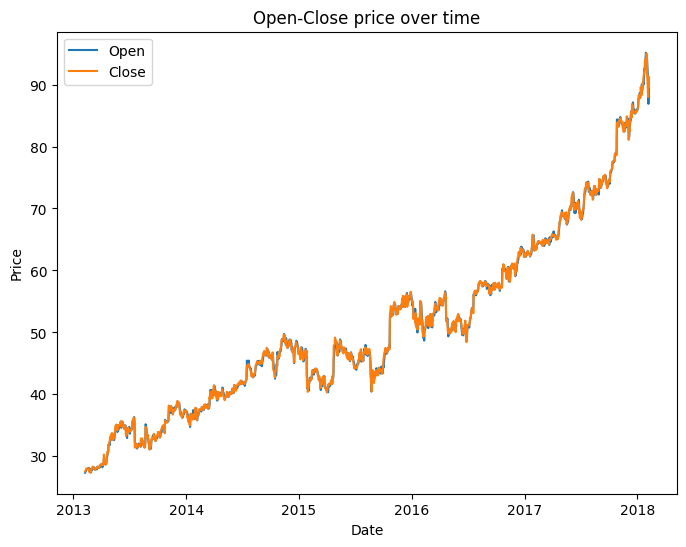

In [437]:
# Plot 1 - Open and Close Prices of time
plt.figure(figsize=(8,6))
plt.plot(df['open'], label='Open')
plt.plot(df['close'], label='Close')
plt.title('Open-Close price over time')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

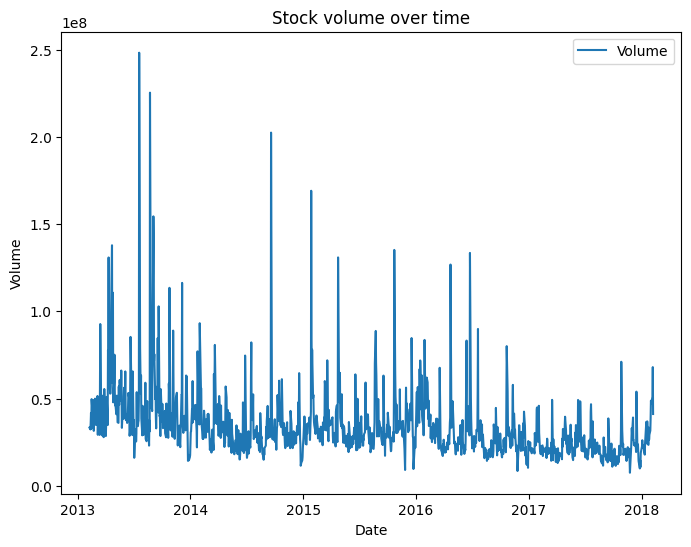

In [438]:
# Plot 2 - Trading Volume (check for outliers)
plt.figure(figsize=(8,6))
plt.plot(df['volume'], label='Volume')
plt.title('Stock volume over time')
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.show()

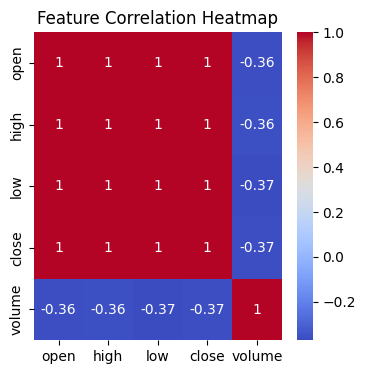

In [439]:
# Plot 3 - Check for correlation between features
plt.figure(figsize=(4,4))
sns.heatmap(df.iloc[:, :-1].corr(), annot=True, cmap="coolwarm" )
plt.title("Feature Correlation Heatmap")
plt.show()

# Prepare for the LSTM Model (Sequential)

### Preprocessing Stages

In [440]:
"""
df[["close"]]              # Returns DataFrame with 'close' column
df.filter(["close"])       # Same result
df.filter(like="clos")     # Will match 'close' if exists
df.filter(regex="cl.*")    # Regex-based column selection
"""

stock_close = df[["close"]]   # This is a Pandas dataframe. with one brackt it will be converted to a series
dataset = stock_close.values  #convert to numpy array

In [441]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)
scaled_data.dtype

dtype('float64')

### # Create a sliding window for our stock (60 days)

In [442]:
# When our dataset is in DataFrame format.
''''
def create_sliding_window_DataFrame(data, window_size, prediction_horizon, stride, target_col):
    X, y = [], []
    for i in range(0, len(data) - window_size - prediction_horizon + 1, stride):
        X.append(data.iloc[i:i + window_size, :].values)
        y.append(data[target_col].iloc[i + window_size:i + window_size + prediction_horizon].values)
    return np.array(X), np.array(y)
    '''


"'\ndef create_sliding_window_DataFrame(data, window_size, prediction_horizon, stride, target_col):\n    X, y = [], []\n    for i in range(0, len(data) - window_size - prediction_horizon + 1, stride):\n        X.append(data.iloc[i:i + window_size, :].values)\n        y.append(data[target_col].iloc[i + window_size:i + window_size + prediction_horizon].values)\n    return np.array(X), np.array(y)\n    "

In the code below, `X` and `y` are `Python lists` (we used .append() in a loop). But to use them in machine learning models (especially LSTM in Keras), they must be `NumPy arrays`.

In [443]:
def create_sliding_window_np(data, window_size, prediction_horizon, stride, target_col_index):
    X, y = [], []
    for i in range(0, len(data) - window_size - prediction_horizon + 1, stride):
        X.append(data[i:i + window_size, :])  # all features in window
        y.append(data[i + window_size:i + window_size + prediction_horizon, target_col_index])  # target column values
    return np.array(X), np.array(y)


In [444]:
window_size = 24         # how many past time steps (days) you use as input to the model.
prediction_horizon = 24   # how many future time steps (days) you want to predict.
stride = 1
target_col_index = 0

X, y = create_sliding_window_np(scaled_data, window_size, prediction_horizon, stride, target_col_index)

# Spliting Date into Training / Validation /Test

In [445]:
train_proportion = 0.8
val_proportion = 0.10
test_proportion = 0.10

total_size = len(X)
train_end = int(train_proportion * total_size)
val_end = int((train_proportion + val_proportion) * total_size)

X_train = X[:train_end]
X_val = X[train_end:val_end]
X_test = X[val_end:]
y_train = y[:train_end]
y_val = y[train_end:val_end]
y_test = y[val_end:]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (969, 24, 1)
X_val shape: (121, 24, 1)
X_test shape: (122, 24, 1)
y_train shape: (969, 24)
y_val shape: (121, 24)
y_test shape: (122, 24)


In [446]:
print(type(X_train))

<class 'numpy.ndarray'>


In [447]:
print(X_train.shape)

(969, 24, 1)


`LSTM models` expect `3D input` in the format:

- [samples, time_steps, features]
 - X_train.shape[0]  ➜ number of samples
 - X_train.shape[1]  ➜ number of time steps (e.g. a 60-day window`)
 - 1                 ➜ number of features (e.g. each window is 1 feature just "close" price)

`In our case, splited data are already in 3D shape. Therefore we do not need to use the reshape function below.`

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


# Build the Model

In [448]:
model = keras.models.Sequential()

In [449]:
# First Layer
model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],1)))

# Second Layer
model.add(keras.layers.LSTM(64, return_sequences=False))

# 3rd Layer (Dense)
model.add(keras.layers.Dense(128, activation="relu"))

# 4th Layer (Dropout)
model.add(keras.layers.Dropout(0.5))

# Final Output Layer
model.add(keras.layers.Dense(1))

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [450]:
learning_rate=0.001
epochs=500
batch_size= 32
patience = 50


optimizer = Adam(learning_rate=learning_rate)

early_stop = EarlyStopping(monitor='val_loss', patience=patience)

model.compile(optimizer=optimizer,
              loss='mae',
              metrics=[keras.metrics.RootMeanSquaredError()]
              )



In [451]:
history = model.fit( X_train,
                     y_train,
                     epochs=epochs,
                     batch_size= batch_size,
                     verbose = 1,
                     validation_data=(X_val, y_val),
                     callbacks = [early_stop]
                     )

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.3364 - root_mean_squared_error: 0.4283 - val_loss: 0.3310 - val_root_mean_squared_error: 0.3540
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.1530 - root_mean_squared_error: 0.1988 - val_loss: 0.1645 - val_root_mean_squared_error: 0.1984
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1494 - root_mean_squared_error: 0.1934 - val_loss: 0.1501 - val_root_mean_squared_error: 0.1823
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1413 - root_mean_squared_error: 0.1848 - val_loss: 0.0869 - val_root_mean_squared_error: 0.1022
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1430 - root_mean_squared_error: 0.1863 - val_loss: 0.0962 - val_root_mean_squared_error: 0.1282
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1373 - root_mean_squared_error: 0.1800 - val_loss: 0.2008 - val_root_mean_squared_error: 0.2275
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step 

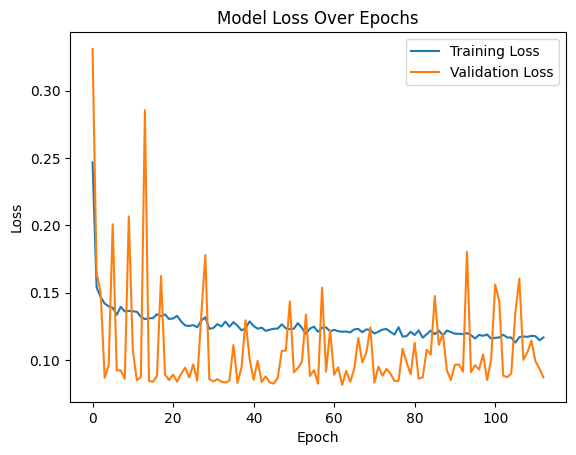

In [452]:
# Plot training loss (e.g. MAE)
plt.plot(history.history['loss'], label='Training Loss')

# If you used validation_split or validation_data, you can also plot validation loss
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Making a Prediction

In [468]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_predicted_flat = predictions


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [457]:
y_test_inv = scaler.inverse_transform(y_test)
y_test_flat = y_test_inv.flatten()

### Plotting Actual vs. Predicted Stock Prices

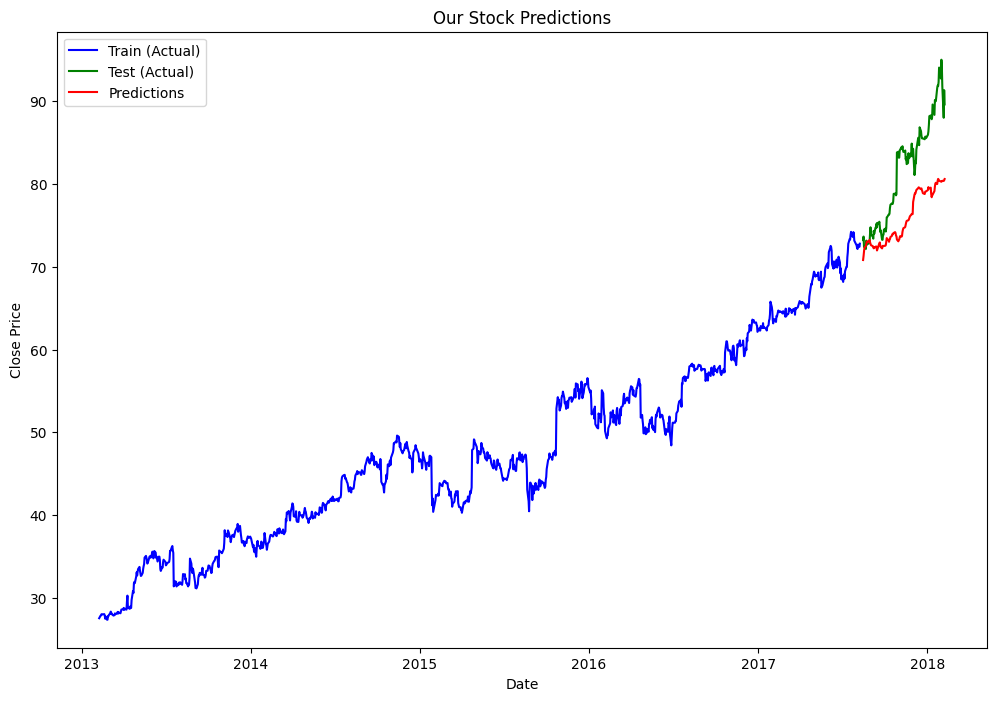

In [454]:
train = df[:int(0.9 * len(df))]  # 80% + 10%
test = df[int(0.9 * len(df)):]   # 10% last portion

test = test[-len(predictions):]  # Only keep the last N rows
test['Predictions'] = predictions.flatten()

plt.figure(figsize=(12,8))
plt.plot( train['close'], label="Train (Actual)", color='blue')
plt.plot(test['close'], label="Test (Actual)", color='green')
plt.plot( test['Predictions'], label="Predictions", color='red')
plt.title("Our Stock Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()